# Same Atom Selection
----
- Same chemical context
- Iterate the same context within one frame
----
- Expect minor changes

In [10]:
import open3d as o3d
import time, builtins, tempfile, datetime, os 
import pickle 
from BetaPose import utils, chemtools, representations; 

import pytraj as pt 
import numpy as np 
from scipy.stats import entropy 
from scipy.ndimage import gaussian_filter 
from scipy.spatial import distance_matrix 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


from BetaPose import utils, cluster

FEATURIZER_PARMS = {
  # Mask of components 
  "MASK_INTEREST" : ":LIG,MDL", 
  "MASK_ENVIRONMENT" : ":1-221",
  
  # POCKET SETTINGS
  "VOXEL_DIMENSION" : [12, 12, 12],    # Unit: 1 (Number of lattice in one dimension)
  "CUBOID_LENGTH" : [8,8,8],           # Unit: Angstorm (Need scaling)
  
  # SEARCH SETTINGS
  "UPDATE_INTERVAL" : 1, 
  "CUTOFF": 18, 
}

# Example workflow

from BetaPose import trajloader, data_io
from BetaPose import features, featurizer


# Load multiple trajectories
# trajs = "/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_001_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_002_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_003_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_004_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_005_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_006_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_007_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_008_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_009_traj.nc%/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_010_traj.nc%"
# tops = ["/home/yzhang/zhang/MyTrajs/BFL-1/batch3/C209CsDJQucZ_job_010_END.pdb"] * 10


trajs = "/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_001_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_002_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_003_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_004_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_005_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_006_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_007_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_009_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_010_traj.nc%"
tops = ["/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb"] * 10
trajs = trajs.strip("%").split("%")
# tloader = trajloader.TrajectoryLoader(trajs, tops);
trajectories = trajloader.TrajectoryLoader(trajs, tops); 

for traj in trajectories: 
  # Complete the trajectory information
  try: 
    traj.strip(":T3P")
  except: 
    pass
  print(traj.traj)
  #### traj.addcharge(); 
  
  # Initialize the featurizer since different trajectory might have distinct parameters
  # featurizer  = featurizer.Featurizer3D(FEATURIZER_PARMS); 
  featurizer  = featurizer.Featurizer3D(FEATURIZER_PARMS); 
  feature_mass = features.MassFeature(); 
  # NOTE: in this step, the feature hooks back the feature and could access the featurizer by feat.featurer
  
  featurizer.register_feature(feature_mass)   # i features
  featurizer.register_traj(traj)
  
  # Fit the standardizer of the input features
#   featurizer.register_frames(range(0, 1000, 20))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA,C,N&:2-145"), fbox_length=[6,6,6])
  
  # A lot of frames and centers
#   featurizer.register_frames(range(0, 1000, 50))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:1-145"), fbox_length=[6,6,6])
  
  # Fix the residues atom and iterate different frames
#   featurizer.register_frames(range(0, 1000, 10))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45"), fbox_length=[6,6,6])
  
  # Fix the frame and iterate different resiudes
  featurizer.register_frames([42]) 
  repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45-145"), fbox_length=[6,6,6])

  # Fix the frames, and iterated load one resdiue TODO
#   featurizer.register_frames([60]) 
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45-145"), fbox_length=[6,6,6])
  
  # featurizer.register_centers() # k centers 
  
  print(repr_traji.shape)
  print(fpfh_traji.shape)
  print(features_traji.shape)
#   featurizer.dump("repr_form", repr_traji, "/tmp/test.h5"); 
#   featurizer.dump("FPFH", np.array([(0,d) for d in fpfh_traji], dtype=object), "/tmp/test.h5"); 
  break
  
import pickle 
thedict = {
  "repr":repr_traji, 
  "fpfh":fpfh_traji, 
  "features":features_traji
}


# Write the object to the file
pickle.dump(thedict, open('TEMP_DATA.pkl', 'wb'))
  
write_scalar = False
if write_scalar: 
#   scaler = StandardScaler()
  scaler = RobustScaler(); 
  scaler.fit(repr_traji); 
  pickle.dump(scaler, open("StandardScaler_model.pkl", "wb"))
  


pytraj.Trajectory, 1001 frames: 
Size: 0.056316 (GB)
<Topology: 2517 atoms, 188 residues, 38 mols, PBC with box type = cubic>
           
23-05-25T17:32:28   : [6 6 6]
23-05-25T17:32:28   : Frame 42: Generated 101 centers
(101, 252) (101, 33, 600) (101, 1, 12, 12, 12)
(101, 252)
(101, 33, 600)
(101, 1, 12, 12, 12)


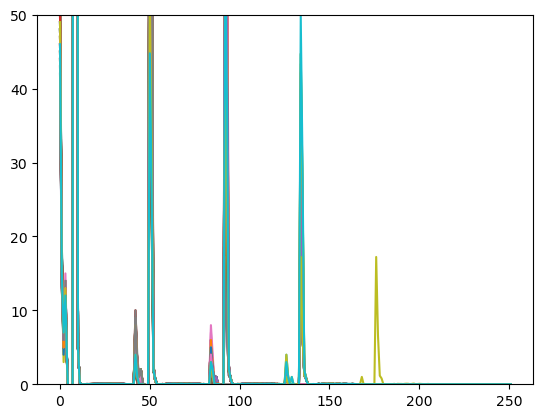

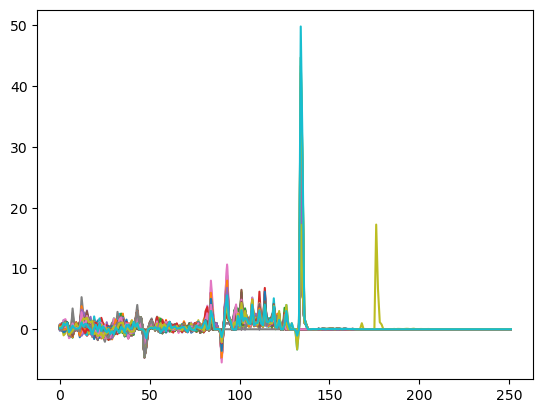

In [9]:
import matplotlib.pyplot as plt 

# write_scalar = True
# if write_scalar: 
#   scaler = StandardScaler()
#   scaler.fit(repr_traji)
#   pickle.dump(scaler, open("StandardScaler_model.pkl", "wb"))

plt.plot(repr_traji.T)
plt.ylim([0,50])
plt.show()
plt.plot(pkl_scaled.T)
plt.show()

[1. 1. 1. 1. 1. 1.]
Chem contribution   :    1.00  1.00  1.00  1.00  1.00  1.00
VP contribution     :    1.00  1.00  1.00  1.00  1.00  1.00
Weights             :    1.00  0.50  0.15  0.10  0.10  0.05
Similarity          :  1.0 

[ 0.63577102 -0.21404278  1.          1.          1.          1.        ]
Chem contribution   :    0.64 -0.21  1.00  1.00  1.00  1.00
VP contribution     :    0.19 -0.39  1.00  1.00  1.00  1.00
Weights             :    1.00  0.50  0.15  0.10  0.10  0.05
Similarity          :  0.34906630173554926 

[-0.02005704 -0.21404278  1.          1.          1.          1.        ]
Chem contribution   :   -0.02 -0.21  1.00  1.00  1.00  1.00
VP contribution     :    0.01 -0.39  1.00  1.00  1.00  1.00
Weights             :    1.00  0.50  0.15  0.10  0.10  0.05
Similarity          :  0.12753772097605154 

[-0.56867436 -0.2455258   1.          1.          1.          1.        ]
Chem contribution   :   -0.57 -0.25  1.00  1.00  1.00  1.00
VP contribution     :   -0.26  0.07  1.

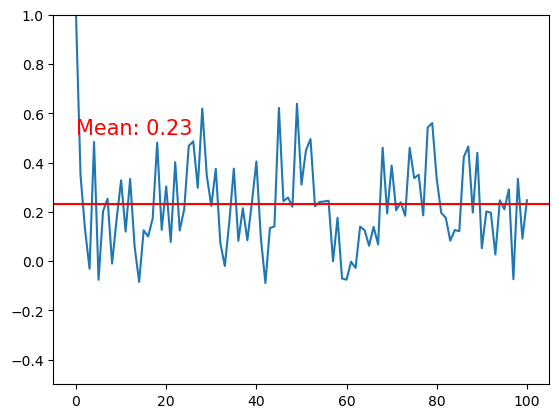

In [11]:
from scipy.spatial import distance
import matplotlib.pyplot as plt 
import numpy as np 
import pickle 

from BetaPose import representations 

# Load the data
with open('TEMP_DATA.pkl', 'rb') as f:
  # Write the object to the file
  thedict = pickle.load(f)
  repr_traji = thedict["repr"]
  
# standardize the data
pkl_model = pickle.load(open("StandardScaler_model.pkl", "rb"))
pkl_scaled = pkl_model.transform(repr_traji)

# plt.plot(pkl_scaled[:,0+(12+30)*0])
# plt.show()

sims = [representations.compute_similarity(pkl_scaled[0], pkl_scaled[i]) for i in range(len(pkl_scaled))]
print("Mean of similarity values: ", np.mean(sims).round(3))

plt.plot(sims)
plt.axhline(y=np.mean(sims), color="r", linestyle="-")
plt.ylim([-0.5,1])
plt.text(0.02, 0.5, f'Mean: {np.mean(sims):.2f}', verticalalignment='bottom', horizontalalignment='left', color='r', fontsize=15)

plt.show()


# The single residue test 

In [4]:
import time, builtins, tempfile, datetime, os, pickle 

import open3d as o3d
import pytraj as pt 
import numpy as np 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from BetaPose import trajloader, utils
from BetaPose import features, featurizer, representations

FEATURIZER_PARMS = {
  # Mask of components 
  "MASK_INTEREST" : ":LIG,MDL", 
  "MASK_ENVIRONMENT" : ":1-221",
  
  # POCKET SETTINGS
  "VOXEL_DIMENSION" : [12, 12, 12],    # Unit: 1 (Number of lattice in one dimension)
  "CUBOID_LENGTH" : [8,8,8],           # Unit: Angstorm (Need scaling)
  
  # SEARCH SETTINGS
  "UPDATE_INTERVAL" : 1, 
  "CUTOFF": 18, 
}

# Load multiple trajectories
trajs = "/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_001_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_002_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_003_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_004_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_005_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_006_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_007_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_009_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_010_traj.nc%"
tops = ["/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb"] * 10
trajs = trajs.strip("%").split("%")

reslist = [14,34]

for resid in reslist: 
  trajectories = trajloader.TrajectoryLoader(trajs, tops, mask=f":{resid}"); 
  for traj in trajectories: 
    # Complete the trajectory information
    try: 
      traj.strip(":T3P")
    except: 
      pass
    print(traj.traj)
    
    # Initialize the featurizer since different trajectory might have distinct parameters
    feat   = featurizer.Featurizer3D(FEATURIZER_PARMS); 
    feature_mass = features.MassFeature(); 
    # NOTE: in this step, the feature hooks back the feature and could access the featurizer by feat.featurer

    feat.register_feature(feature_mass)   # i features
    feat.register_traj(traj)

    print("Processing ====>", list(traj.top.residues)[0])
    # Fix the frame and iterate different resiudes
    feat.register_frames([42]) 
    repr_traji, fpfh_traji, features_traji = feat.run_by_atom(traj.top.select(f"@CA&:1"), fbox_length=[6,6,6])

    print("Featurization: finished", repr_traji.shape)
    break
  
import pickle 
thedict = {
  "repr":repr_traji, 
  "fpfh":fpfh_traji, 
  "features":features_traji
}

# Write the object to the file
pickle.dump(thedict, open('TEMP_DATA.pkl', 'wb'))  


pytraj.Trajectory, 1001 frames: 
Size: 0.000380 (GB)
<Topology: 17 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <GLN13, 17 atoms>
23-05-25T17:57:26   : [6 6 6]
23-05-25T17:57:26   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
Featurization: finished (1, 252)
pytraj.Trajectory, 1001 frames: 
Size: 0.000246 (GB)
<Topology: 11 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <SER33, 11 atoms>
23-05-25T17:57:26   : [6 6 6]
23-05-25T17:57:26   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 1

# Same Center 
----
- Similar chemical context since trajectory is aligned
- Iterate different frames with one center 
----
- Expect minor changes

In [11]:
x =  np.arange(10)

b =  np.arange(10)-5

def cossim(a, b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

cossim(b,x)

0.38549553972194134

# Different Atom Selection
----
- Different chemical context
- Iterate different context within one frame
----
- Expect significant change

In [3]:
x = [np.nan, np.nan, np.nan]


# Viewpoint Feature histogram


In [ ]:
import numpy as np

def compute_vfh(points, normals, viewpoint, bins=45):
  # Compute the centroid
  centroid = np.mean(points, axis=0); 
  # Compute the direction from the centroid to each point
  directions = viewpoint - centroid; 
  # Compute the angles between the directions and the normals
  angles = np.arccos(np.sum(normals * directions, axis=1) / np.linalg.norm(directions, axis=1))
  # Compute the viewpoint component histogram
  vfh_hist_viewpoint, _ = np.histogram(angles, bins=bins, range=(0, np.pi))

  # Compute the Extended FPFH component for each point
  extended_fpfh = np.zeros((len(points), bins))

  for i, (point, normal) in enumerate(zip(points, normals)):
      k_neighbors = np.arange(len(points))
      k_neighbors = k_neighbors[k_neighbors != i]
      extended_fpfh[i] = compute_pfh(points, normals, i, k_neighbors, bins)

  # Compute the Extended FPFH histogram by summing up the histograms for all points
  vfh_hist_extended = np.sum(extended_fpfh, axis=0)

  # Normalize the histograms
  vfh_hist_viewpoint = vfh_hist_viewpoint / np.sum(vfh_hist_viewpoint)
  vfh_hist_extended = vfh_hist_extended / np.sum(vfh_hist_extended)

  # Concatenate the viewpoint and extended histograms to form the VFH
  vfh = np.concatenate((vfh_hist_viewpoint, vfh_hist_extended))

  return vfh


In [5]:
import numpy as np 
import open3d as o3d
import time
from BetaPose import utils

from matplotlib.cm import inferno

def calc_tm(roll, pitch, yaw, translate=[0, 0, 0]):
    # Precompute trigonometric functions
    cos_roll, sin_roll = np.cos(roll), np.sin(roll)
    cos_pitch, sin_pitch = np.cos(pitch), np.sin(pitch)
    cos_yaw, sin_yaw = np.cos(yaw), np.sin(yaw)

    # Generate rotation matrices
    Rx = np.array([[1, 0, 0], [0, cos_roll, -sin_roll], [0, sin_roll, cos_roll]])
    Ry = np.array([[cos_pitch, 0, sin_pitch], [0, 1, 0], [-sin_pitch, 0, cos_pitch]])
    Rz = np.array([[cos_yaw, -sin_yaw, 0], [sin_yaw, cos_yaw, 0], [0, 0, 1]])

    # Combine rotations
    R = Rx @ Ry @ Rz

    # Create the final transformation matrix
    H = np.eye(4); 
    H[:3, :3] = R; 
    H[:3, 3] = np.array(translate).ravel()

    return H


def transform_pcd(pcd, trans_mtx): 
  # Homogenize the point cloud (add a row of ones)
  homogeneous_pcd = np.hstack((pcd, np.ones((pcd.shape[0], 1))));
  # Apply the transformation matrix to the point cloud
  transformed_pcd = np.dot(homogeneous_pcd, trans_mtx.T);
  # Remove the homogeneous coordinate (last column)
  transformed_pcd = transformed_pcd[:, :3];
  return transformed_pcd
  

pcd = np.arange(102*3).reshape(-1,3)
# pcd = np.asarray([np.zeros(102),np.zeros(102), np.arange(102)]).T
print(pcd)
pcd_out = np.array(pcd)

t1 = time.perf_counter()

for r in np.linspace(0, np.pi*2, 20): 
  for p in np.linspace(0, np.pi*2, 20): 
    for z in np.linspace(0, np.pi*2, 20): 
      TransMatrix = utils.calc_tm(r, p , z)
      pcd2 = utils.transform_pcd(pcd, TransMatrix)
      pcd_out = np.vstack((pcd_out, pcd2))
  
  
print("Method1: ", time.perf_counter() - t1,)
# print(pcd2)


# import matplotlib.pyplot as plt 

point_cloud = o3d.geometry.PointCloud()

# Set the points of the point cloud object
point_cloud.points = o3d.utility.Vector3dVector(pcd_out)

thecmap = inferno(np.linspace(0,1,len(pcd_out)))[:, :3]
print(thecmap)

point_cloud.colors = o3d.utility.Vector3dVector(thecmap)


# Visualize the point cloud
o3d.visualization.draw_geometries([point_cloud])




[[  0   1   2]
 [  3   4   5]
 [  6   7   8]
 ...
 [297 298 299]
 [300 301 302]
 [303 304 305]]
Method1:  6.0915879950043745
[[1.46200e-03 4.66000e-04 1.38660e-02]
 [1.46200e-03 4.66000e-04 1.38660e-02]
 [1.46200e-03 4.66000e-04 1.38660e-02]
 ...
 [9.88362e-01 9.98364e-01 6.44924e-01]
 [9.88362e-01 9.98364e-01 6.44924e-01]
 [9.88362e-01 9.98364e-01 6.44924e-01]]


In [10]:
pcd = np.arange(102*3).reshape(-1,3)
np.vstack((pcd,pcd))

array([[  0,   1,   2],
       [  3,   4,   5],
       [  6,   7,   8],
       [  9,  10,  11],
       [ 12,  13,  14],
       [ 15,  16,  17],
       [ 18,  19,  20],
       [ 21,  22,  23],
       [ 24,  25,  26],
       [ 27,  28,  29],
       [ 30,  31,  32],
       [ 33,  34,  35],
       [ 36,  37,  38],
       [ 39,  40,  41],
       [ 42,  43,  44],
       [ 45,  46,  47],
       [ 48,  49,  50],
       [ 51,  52,  53],
       [ 54,  55,  56],
       [ 57,  58,  59],
       [ 60,  61,  62],
       [ 63,  64,  65],
       [ 66,  67,  68],
       [ 69,  70,  71],
       [ 72,  73,  74],
       [ 75,  76,  77],
       [ 78,  79,  80],
       [ 81,  82,  83],
       [ 84,  85,  86],
       [ 87,  88,  89],
       [ 90,  91,  92],
       [ 93,  94,  95],
       [ 96,  97,  98],
       [ 99, 100, 101],
       [102, 103, 104],
       [105, 106, 107],
       [108, 109, 110],
       [111, 112, 113],
       [114, 115, 116],
       [117, 118, 119],
       [120, 121, 122],
       [123, 124

In [7]:
_pcd = np.arange(100).reshape((-1,4))
c = np.mean(_pcd, axis = 0); 
print(c)

[48. 49. 50. 51.]


In [32]:
import matplotlib.pyplot as plt 
import time


class VFH(object):
  """
  Parent class for PFH
  """

  def __init__(self, div, nneighbors, rad):
    """
    Pass in parameters
    """
    self._div = div
    self._nneighbors = nneighbors
    self._radius = rad

    self._error_list = []
    self._Rlist = []
    self._tlist = []
    self._pcd = np.array([])
    print("After initializaiton");

  def push_pcd(self, pcd, norm):
    if len(self._pcd) > 0:
      self._pcd = np.vstack(self._pcd, pcd);
      self._norm = np.vstack(self._norm, norm);
    else:
      self._pcd = np.array(pcd);
      self._norm = np.array(norm);
    self.N = len(self._pcd);
    self._kdtree = spatial.KDTree(self._pcd);

  def get_neighbors(self, pq):
    """
    Get k nearest neighbors of the query point pq from pc within the radius using KDTree.

    :param pq: Query point (1D numpy array of shape (3,))
    :param pc: Point cloud (2D numpy array of shape (N, 3))
    :return: Indices of the k nearest neighbors within the radius, distances of the k nearest neighbors
    """

    distances, indices = self._kdtree.query(pq, k=self._nneighbors+1, distance_upper_bound=self._radius)
    # Filter out neighbors with infinite distance (outside the search radius)
    valid_neighbors = np.isfinite(distances)
    indices = indices[valid_neighbors]
    distances = distances[valid_neighbors]
    return distances, indices

  def compute_fpfh(self):
    
    pass
  
  def compute_efpfh(self):
    pcd_center = np.mean(self._pcd, axis=0);

    for point_idx in range(self.N):
      pi = self._pcd[point_idx];
      ni = self._norm[point_idx];
      
      _, neighbor_idx = self.get_neighbors(pi);
      neighbors = neighbor_idx.tolist(); 
      neighbors.remove(point_idx);    # Remove the original query point
      # print(f"#### {len(neighbor_idx)} points queried")
      # print(point_idx, "=>" , neighbors)
      for nb_idx in neighbors: 
        u = self._norm[nb_idx]; 
        v = np.cross(pi-pcd_center, u)
        w = np.cross(u, v)
        dist = np.linalg.norm(vc)

        alpha = np.dot(v, u)
        phi = np.dot(u, vc)
        theta = np.arctan(np.dot(w, u) / np.dot(u, u))
        
  def compute_vpc(self, viewpoint, bins=128): 
    
    # Compute the relative position of the viewpoint to each point in the cloud
    rel_viewpoint = np.asarray(viewpoint) - self._pcd.mean(axis=0)
    print(rel_viewpoint)

    # Normalize the relative viewpoint vectors
    rel_viewpoint_normalized = rel_viewpoint / np.linalg.norm(rel_viewpoint) #[:, np.newaxis]
    print(rel_viewpoint_normalized, rel_viewpoint_normalized.shape)

    # Calculate the angle between the normals and the relative viewpoint vectors
    cos_angles = np.sum(self._norm * rel_viewpoint_normalized, axis=1)
    angles = np.arccos(cos_angles)
    
    print(np.dot(self._norm, rel_viewpoint_normalized))
    for i in self._norm: 
      print(np.dot(i, rel_viewpoint_normalized))

    # Create the viewpoint component histogram
    hist, _ = np.histogram(angles, bins=bins, range=(0, np.pi))

    # Normalize the histogram
    hist_normalized = hist / np.sum(hist)
#     plt.plot(np.arange(len(hist_normalized)), hist_normalized)
#     plt.show()
    return hist_normalized

        


div = 2
nneighbors = 8
rad = 0.8

import open3d as o3d
import numpy as np
from scipy import spatial

mesh = o3d.io.read_triangle_mesh("/media/yzhang/MieT5/BetaPose/tests/test.ply")

pcd = np.array(mesh.vertices)
# [1200:1800]
norms = np.array(mesh.vertex_normals)
# [1200:1800]
print(pcd.shape, norms.shape)

vfh_container = VFH(div, nneighbors, rad)
vfh_container.push_pcd(pcd, norms); 
print(pcd)

# vfh_container.calc_viewpoint([10,10,10])
# vfh_container.testvfh2([10,10,10])
vfh_container.compute_vpc([10,10,10])

# st = time.perf_counter()
# for i in range(1000): 
#   vfh_container.testvfh2([10,10,10])
# print(time.perf_counter() - st); 






(1390, 3) (1390, 3)
After initializaiton
[[26.198 36.691 27.022]
 [26.539 36.543 27.084]
 [27.075 35.093 28.329]
 ...
 [25.278 32.841 25.679]
 [25.278 33.361 25.679]
 [25.159 33.101 26.13 ]]
[-20.25565252 -25.68393525 -18.78254748]
[-0.53701134 -0.68092422 -0.49795685] (3,)
[0.52718426 0.5938493  0.50031737 ... 0.83792112 0.52964206 0.53701134]
0.5271842627685688
0.5938492969508882
0.5003173683467622
0.8732540340468018
0.7816073270795973
0.8173920929446075
0.5668221641191383
0.5322932213596699
0.8792227776861242
-0.021205475849279898
-0.4741820873481106
0.1945349586270783
-0.20987448735078806
-0.7908499102819864
-0.5163115634085433
-0.34434778788964315
-0.7104123318205928
0.5334592254645619
-0.1406797840771912
0.33179730528938844
0.7582596151272685
-0.41936701288798606
-0.00335659706607333
0.24561628415221654
-0.06160551709695791
0.23233380824172234
0.4985848355839647
0.28718537433198266
0.46085053480574456
0.7015156956252413
0.536571099753376
0.43618392046274773
0.5128476647820629
0.4

array([0.        , 0.        , 0.00071942, 0.00143885, 0.00215827,
       0.00071942, 0.00143885, 0.00215827, 0.00503597, 0.00143885,
       0.00143885, 0.        , 0.00431655, 0.0057554 , 0.00431655,
       0.00791367, 0.0028777 , 0.00431655, 0.00359712, 0.0057554 ,
       0.00647482, 0.00647482, 0.00647482, 0.00719424, 0.00359712,
       0.01007194, 0.01007194, 0.01151079, 0.00863309, 0.00647482,
       0.01079137, 0.00719424, 0.01079137, 0.00791367, 0.00863309,
       0.00719424, 0.01079137, 0.01151079, 0.00863309, 0.01223022,
       0.01007194, 0.01366906, 0.00863309, 0.01366906, 0.01366906,
       0.00719424, 0.01079137, 0.00863309, 0.00647482, 0.01151079,
       0.01007194, 0.00647482, 0.01438849, 0.01079137, 0.00863309,
       0.00935252, 0.01079137, 0.01510791, 0.00863309, 0.01726619,
       0.01366906, 0.01438849, 0.01582734, 0.01223022, 0.01079137,
       0.00791367, 0.00935252, 0.01007194, 0.01582734, 0.00791367,
       0.01582734, 0.01151079, 0.01726619, 0.0057554 , 0.01223

In [3]:

import open3d as o3d
import matplotlib.pyplot as plt 
import open3d as o3d
import numpy as np
from scipy import spatial

In [36]:
np.arange(1,4)*np.arange(1,4)

np.arange(1,4).dot(np.arange(1,4))


14

In [1]:
import numpy as np
from BetaPose import utils

def uv(vector):
    return vector / np.linalg.norm(vector)

def ea_vectors(v1, v2):
    # Normalize both vectors
    v1_unit = v1/np.linalg.norm(v1)
    v2_unit = v2/np.linalg.norm(v2)

    # Calculate the cross product and dot product of the vectors
    cross = np.cross(v1_unit, v2_unit)
    dot = np.dot(v1_unit, v2_unit)

    # Calculate the angle between the vectors
    angle = np.arccos(np.clip(dot, -1.0, 1.0))

    # Calculate the axis of rotation
    axis = cross / np.linalg.norm(cross)

    # Calculate the quaternion
    qw = np.cos(angle / 2)
    qx, qy, qz = axis * np.sin(angle / 2)

    # Convert quaternion to Euler angles
    roll = np.arctan2(2 * (qw * qx + qy * qz), 1 - 2 * (qx * qx + qy * qy))
    pitch = np.arcsin(2 * (qw * qy - qz * qx))
    yaw = np.arctan2(2 * (qw * qz + qx * qy), 1 - 2 * (qy * qy + qz * qz))

    return roll, pitch, yaw

v1 = np.array([1, 0, 0])
v2 = np.array([3, 2, 1])

roll, pitch, yaw = ea_vectors(v1, v2)
print(f"Roll: {roll}, Pitch: {pitch}, Yaw: {yaw}")

Roll: -0.0823726211170212, Pitch: -0.27054976297857286, Yaw: 0.5880026035475675


In [70]:
tm = utils.calc_tm(roll, pitch, yaw); 
print(tm)
totrans = np.array([v2])
print(totrans)

ret = utils.transform_pcd(totrans, tm)
print(np.round(uv(ret),2), "diff", np.round((uv(ret) / uv(v1)), 2))

[[ 0.80178373 -0.53452248 -0.26726124  0.        ]
 [ 0.57111626  0.81703113  0.07928651  0.        ]
 [ 0.17598033 -0.21620787  0.96035675  0.        ]
 [ 0.          0.          0.          1.        ]]
[[3 2 1]]
[[0.29 0.92 0.28]] diff [[0.29  inf  inf]]


/tmp/ipykernel_10361/3694480922.py:7: RuntimeWarning: divide by zero encountered in true_divide
  print(np.round(uv(ret),2), "diff", np.round((uv(ret) / uv(v1)), 2))


In [39]:
import numpy as np

def compute_angles(v1, v2):
    # Normalize vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)

    # Compute the cross product of the two vectors
    cross = np.cross(v1_norm, v2_norm)

    # Compute the dot product of the two vectors
    dot = np.dot(v1_norm, v2_norm)

    # Compute the magnitude of the cross product and the angle between the two vectors
    mag_cross = np.linalg.norm(cross)
    angle = np.arccos(dot)

    # Compute the rotation matrix around the cross product vector
    if mag_cross != 0:
        cross_norm = cross / mag_cross
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        R = np.array([[cos_angle + cross_norm[0]**2*(1-cos_angle), cross_norm[0]*cross_norm[1]*(1-cos_angle) - cross_norm[2]*sin_angle, cross_norm[0]*cross_norm[2]*(1-cos_angle) + cross_norm[1]*sin_angle],
                      [cross_norm[1]*cross_norm[0]*(1-cos_angle) + cross_norm[2]*sin_angle, cos_angle + cross_norm[1]**2*(1-cos_angle), cross_norm[1]*cross_norm[2]*(1-cos_angle) - cross_norm[0]*sin_angle],
                      [cross_norm[2]*cross_norm[0]*(1-cos_angle) - cross_norm[1]*sin_angle, cross_norm[2]*cross_norm[1]*(1-cos_angle) + cross_norm[0]*sin_angle, cos_angle + cross_norm[2]**2*(1-cos_angle)]])
    else:
        R = np.eye(3)

    # Compute the roll, pitch, and yaw angles from the rotation matrix
    yaw = np.arctan2(R[1, 0], R[0, 0])
    pitch = np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2))
    roll = np.arctan2(R[2, 1], R[2, 2])

    return roll, pitch, yaw
  
eas = compute_angles(v1,v2)
tm = utils.calc_tm(*eas); 
ret = utils.transform_pcd(np.array([v2]), tm)
print(ret.round(2))



[[-0.82  0.96  0.64]]


In [28]:
s = pt.load("/tmp/structure_frame940.pdb")
dir(list(s.top.bonds)[0])
list(s.top.bonds)[0].indices

array([0, 1])

In [39]:
import numpy as np
from Bio.PDB import PDBParser
import open3d as o3d



def rotation_matrix_from_vectors(vec1, vec2):
  """ Find the rotation matrix that aligns vec1 to vec2
  :param vec1: A 3d "source" vector
  :param vec2: A 3d "destination" vector
  :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
  """
  a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
  v = np.cross(a, b)
  c = np.dot(a, b)
  s = np.linalg.norm(v)
  kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
  rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
  return rotation_matrix
  
def create_sphere(center, radius=0.5, color=[0, 0, 1]):
  sphere = o3d.geometry.TriangleMesh.create_sphere(radius)
  sphere.paint_uniform_color(color)
  sphere.translate(center)
  sphere.compute_vertex_normals()
  return sphere

  
def create_cylinder(start, end, radius=0.2, color=[0.4275, 0.2941, 0.0745]):
  vec = end - start
  length = np.linalg.norm(vec)
  cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius, length)
  cylinder.paint_uniform_color(color)
  
  direction = vec / length
  rot = rotation_matrix_from_vectors([0, 0, 1], direction)  # Change to z-axis
  cylinder.rotate(rot, center=[0, 0, 0])  # Rotate around the origin
  
  mid = (start + end) / 2
  cylinder.translate(mid - cylinder.get_center())
  cylinder.compute_vertex_normals()
  return cylinder

def molecule_to_o3d(pdb_path):
  # Load PDB structure
  structure = pt.load(pdb_path); 

  # Visualization
  geometries = []
  atoms = list(structure.top.atoms)
  coords = list(structure.xyz[0])
  print(atoms, coords)
  for idx, c in enumerate(coords): 
    theatom = atoms[idx]; 
    color = element_color_map[theatom.name[0]]; 
    print(color)
    geometries.append(create_sphere(c, color=color)); 
    
  for bond in list(s.top.bonds): 
    n_i, n_j = bond.indices
    pos_1 = coords[n_i]
    pos_2 = coords[n_j]
    print(pos_1, pos_2)
    if np.linalg.norm(pos_1 - pos_2) < 3:  # Simple condition to check if there is a bond
      geometries.append(create_cylinder(pos_1, pos_2))
  return geometries

geometries = molecule_to_o3d('/tmp/structure_frame990.pdb')
mesh = o3d.io.read_triangle_mesh("/tmp/MSMS_OBJ_z1lw_j1o.ply")
mesh.paint_uniform_color([0.5,0.1,0.1])
print(dir(mesh))

element_color_map = {
  "C": [0.5, 0.5, 0.5],
  "H": [1,1,1],
  "O": [1,0,0], 
  "N": [0,0,1],
  "S": [0,1,1],
}

lineset = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
final_geometries = geometries + [lineset]

# Visualize the wireframe representation
o3d.visualization.draw_geometries(final_geometries)

# Apply the material to the mesh
# mesh.material = material

# mesh.compute_vertex_normals()

# o3d.visualization.draw_geometries(final_geometries)

[Atom(name=N, type=, atomic_number=7, index=0, resid=0), Atom(name=CA, type=, atomic_number=6, index=1, resid=0), Atom(name=C, type=, atomic_number=6, index=2, resid=0), Atom(name=O, type=, atomic_number=8, index=3, resid=0), Atom(name=CB, type=, atomic_number=6, index=4, resid=0), Atom(name=CG, type=, atomic_number=6, index=5, resid=0), Atom(name=CD, type=, atomic_number=6, index=6, resid=0), Atom(name=OE1, type=, atomic_number=8, index=7, resid=0), Atom(name=NE2, type=, atomic_number=7, index=8, resid=0)] [array([33.623, 31.64 , 23.15 ]), array([33.575, 33.092, 23.302]), array([34.277, 33.875, 22.238]), array([33.679, 34.727, 21.537]), array([33.993, 33.623, 24.701]), array([32.931, 33.238, 25.711]), array([33.258, 33.793, 27.172]), array([33.318, 33.092, 28.113]), array([33.453, 35.111, 27.242])]
[0, 0, 1]
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]
[1, 0, 0]
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]
[1, 0, 0]
[0, 0, 1]
[33.623 31.64  23.15 ] [33.575 33.092 23.302]
[33.575 33.092 23.302] 